# Lab 3 — dimensionality reduction

## Setup

In [2]:
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np

from operator import itemgetter

from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
from pyspark.mllib.linalg.distributed import RowMatrix, CoordinateMatrix, MatrixEntry

In [3]:
%matplotlib inline
plt.style.use("ggplot")

sqlContext = SQLContext(sc)

In [4]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 5

{"tagId": 1124, "tag": "writing"}
{"tagId": 1125, "tag": "wuxia"}
{"tagId": 1126, "tag": "wwii"}
{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}


In [5]:
!hdfs dfs -cat /ix/ml-20m/genome-scores.txt | tail -n 5

{"relevance": 0.58775, "tagId": 1124, "movieId": 131170}
{"relevance": 0.010749999999999982, "tagId": 1125, "movieId": 131170}
{"relevance": 0.015749999999999986, "tagId": 1126, "movieId": 131170}
{"relevance": 0.11449999999999999, "tagId": 1127, "movieId": 131170}
{"relevance": 0.02174999999999999, "tagId": 1128, "movieId": 131170}


In [6]:
data = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
dataS = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)

## Exercise 3.1

In [7]:
tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())
tagIds = data.map(lambda x: int(x["tagId"]))
M = tagIds.max()

In [8]:
movieIds = dataS.map(lambda x: int(x["movieId"])).distinct()
N = movieIds.count()

In [9]:
scores = dataS.map(lambda r: Row(movieId=r.get("movieId"), tagId=r.get("tagId"), relevance=r.get("relevance")))
schemaScores = sqlContext.createDataFrame(scores)
schemaScores.registerTempTable("scores")

In [10]:
mat = CoordinateMatrix(dataS.map(lambda r: 
        MatrixEntry(r.get("movieId"), r.get("tagId"), r.get("relevance"))))

rm = mat.toRowMatrix()

m = mat.numRows()
n = mat.numCols()

In [11]:
rows = rm.rows

In [12]:
#print(m)
#print(n)

#print(rm.numRows())
#print(rm.numCols())

#print(M)
#print(N)
#print(dataS.count())

In [13]:
dM = np.empty((M, N))

for i, row in enumerate(rows.collect()):
    print("Processed row", i)
    for j in range(1, 1129):
        dM[j-1, i] = row[j]

Processed row 0
Processed row 1
Processed row 2
Processed row 3
Processed row 4
Processed row 5
Processed row 6
Processed row 7
Processed row 8
Processed row 9
Processed row 10
Processed row 11
Processed row 12
Processed row 13
Processed row 14
Processed row 15
Processed row 16
Processed row 17
Processed row 18
Processed row 19
Processed row 20
Processed row 21
Processed row 22
Processed row 23
Processed row 24
Processed row 25
Processed row 26
Processed row 27
Processed row 28
Processed row 29
Processed row 30
Processed row 31
Processed row 32
Processed row 33
Processed row 34
Processed row 35
Processed row 36
Processed row 37
Processed row 38
Processed row 39
Processed row 40
Processed row 41
Processed row 42
Processed row 43
Processed row 44
Processed row 45
Processed row 46
Processed row 47
Processed row 48
Processed row 49
Processed row 50
Processed row 51
Processed row 52
Processed row 53
Processed row 54
Processed row 55
Processed row 56
Processed row 57
Processed row 58
Process

Processed row 479
Processed row 480
Processed row 481
Processed row 482
Processed row 483
Processed row 484
Processed row 485
Processed row 486
Processed row 487
Processed row 488
Processed row 489
Processed row 490
Processed row 491
Processed row 492
Processed row 493
Processed row 494
Processed row 495
Processed row 496
Processed row 497
Processed row 498
Processed row 499
Processed row 500
Processed row 501
Processed row 502
Processed row 503
Processed row 504
Processed row 505
Processed row 506
Processed row 507
Processed row 508
Processed row 509
Processed row 510
Processed row 511
Processed row 512
Processed row 513
Processed row 514
Processed row 515
Processed row 516
Processed row 517
Processed row 518
Processed row 519
Processed row 520
Processed row 521
Processed row 522
Processed row 523
Processed row 524
Processed row 525
Processed row 526
Processed row 527
Processed row 528
Processed row 529
Processed row 530
Processed row 531
Processed row 532
Processed row 533
Processed 

Processed row 974
Processed row 975
Processed row 976
Processed row 977
Processed row 978
Processed row 979
Processed row 980
Processed row 981
Processed row 982
Processed row 983
Processed row 984
Processed row 985
Processed row 986
Processed row 987
Processed row 988
Processed row 989
Processed row 990
Processed row 991
Processed row 992
Processed row 993
Processed row 994
Processed row 995
Processed row 996
Processed row 997
Processed row 998
Processed row 999
Processed row 1000
Processed row 1001
Processed row 1002
Processed row 1003
Processed row 1004
Processed row 1005
Processed row 1006
Processed row 1007
Processed row 1008
Processed row 1009
Processed row 1010
Processed row 1011
Processed row 1012
Processed row 1013
Processed row 1014
Processed row 1015
Processed row 1016
Processed row 1017
Processed row 1018
Processed row 1019
Processed row 1020
Processed row 1021
Processed row 1022
Processed row 1023
Processed row 1024
Processed row 1025
Processed row 1026
Processed row 1027


Processed row 1493
Processed row 1494
Processed row 1495
Processed row 1496
Processed row 1497
Processed row 1498
Processed row 1499
Processed row 1500
Processed row 1501
Processed row 1502
Processed row 1503
Processed row 1504
Processed row 1505
Processed row 1506
Processed row 1507
Processed row 1508
Processed row 1509
Processed row 1510
Processed row 1511
Processed row 1512
Processed row 1513
Processed row 1514
Processed row 1515
Processed row 1516
Processed row 1517
Processed row 1518
Processed row 1519
Processed row 1520
Processed row 1521
Processed row 1522
Processed row 1523
Processed row 1524
Processed row 1525
Processed row 1526
Processed row 1527
Processed row 1528
Processed row 1529
Processed row 1530
Processed row 1531
Processed row 1532
Processed row 1533
Processed row 1534
Processed row 1535
Processed row 1536
Processed row 1537
Processed row 1538
Processed row 1539
Processed row 1540
Processed row 1541
Processed row 1542
Processed row 1543
Processed row 1544
Processed ro

Processed row 2062
Processed row 2063
Processed row 2064
Processed row 2065
Processed row 2066
Processed row 2067
Processed row 2068
Processed row 2069
Processed row 2070
Processed row 2071
Processed row 2072
Processed row 2073
Processed row 2074
Processed row 2075
Processed row 2076
Processed row 2077
Processed row 2078
Processed row 2079
Processed row 2080
Processed row 2081
Processed row 2082
Processed row 2083
Processed row 2084
Processed row 2085
Processed row 2086
Processed row 2087
Processed row 2088
Processed row 2089
Processed row 2090
Processed row 2091
Processed row 2092
Processed row 2093
Processed row 2094
Processed row 2095
Processed row 2096
Processed row 2097
Processed row 2098
Processed row 2099
Processed row 2100
Processed row 2101
Processed row 2102
Processed row 2103
Processed row 2104
Processed row 2105
Processed row 2106
Processed row 2107
Processed row 2108
Processed row 2109
Processed row 2110
Processed row 2111
Processed row 2112
Processed row 2113
Processed ro

Processed row 2506
Processed row 2507
Processed row 2508
Processed row 2509
Processed row 2510
Processed row 2511
Processed row 2512
Processed row 2513
Processed row 2514
Processed row 2515
Processed row 2516
Processed row 2517
Processed row 2518
Processed row 2519
Processed row 2520
Processed row 2521
Processed row 2522
Processed row 2523
Processed row 2524
Processed row 2525
Processed row 2526
Processed row 2527
Processed row 2528
Processed row 2529
Processed row 2530
Processed row 2531
Processed row 2532
Processed row 2533
Processed row 2534
Processed row 2535
Processed row 2536
Processed row 2537
Processed row 2538
Processed row 2539
Processed row 2540
Processed row 2541
Processed row 2542
Processed row 2543
Processed row 2544
Processed row 2545
Processed row 2546
Processed row 2547
Processed row 2548
Processed row 2549
Processed row 2550
Processed row 2551
Processed row 2552
Processed row 2553
Processed row 2554
Processed row 2555
Processed row 2556
Processed row 2557
Processed ro

Processed row 3015
Processed row 3016
Processed row 3017
Processed row 3018
Processed row 3019
Processed row 3020
Processed row 3021
Processed row 3022
Processed row 3023
Processed row 3024
Processed row 3025
Processed row 3026
Processed row 3027
Processed row 3028
Processed row 3029
Processed row 3030
Processed row 3031
Processed row 3032
Processed row 3033
Processed row 3034
Processed row 3035
Processed row 3036
Processed row 3037
Processed row 3038
Processed row 3039
Processed row 3040
Processed row 3041
Processed row 3042
Processed row 3043
Processed row 3044
Processed row 3045
Processed row 3046
Processed row 3047
Processed row 3048
Processed row 3049
Processed row 3050
Processed row 3051
Processed row 3052
Processed row 3053
Processed row 3054
Processed row 3055
Processed row 3056
Processed row 3057
Processed row 3058
Processed row 3059
Processed row 3060
Processed row 3061
Processed row 3062
Processed row 3063
Processed row 3064
Processed row 3065
Processed row 3066
Processed ro

Processed row 3684
Processed row 3685
Processed row 3686
Processed row 3687
Processed row 3688
Processed row 3689
Processed row 3690
Processed row 3691
Processed row 3692
Processed row 3693
Processed row 3694
Processed row 3695
Processed row 3696
Processed row 3697
Processed row 3698
Processed row 3699
Processed row 3700
Processed row 3701
Processed row 3702
Processed row 3703
Processed row 3704
Processed row 3705
Processed row 3706
Processed row 3707
Processed row 3708
Processed row 3709
Processed row 3710
Processed row 3711
Processed row 3712
Processed row 3713
Processed row 3714
Processed row 3715
Processed row 3716
Processed row 3717
Processed row 3718
Processed row 3719
Processed row 3720
Processed row 3721
Processed row 3722
Processed row 3723
Processed row 3724
Processed row 3725
Processed row 3726
Processed row 3727
Processed row 3728
Processed row 3729
Processed row 3730
Processed row 3731
Processed row 3732
Processed row 3733
Processed row 3734
Processed row 3735
Processed ro

Processed row 4160
Processed row 4161
Processed row 4162
Processed row 4163
Processed row 4164
Processed row 4165
Processed row 4166
Processed row 4167
Processed row 4168
Processed row 4169
Processed row 4170
Processed row 4171
Processed row 4172
Processed row 4173
Processed row 4174
Processed row 4175
Processed row 4176
Processed row 4177
Processed row 4178
Processed row 4179
Processed row 4180
Processed row 4181
Processed row 4182
Processed row 4183
Processed row 4184
Processed row 4185
Processed row 4186
Processed row 4187
Processed row 4188
Processed row 4189
Processed row 4190
Processed row 4191
Processed row 4192
Processed row 4193
Processed row 4194
Processed row 4195
Processed row 4196
Processed row 4197
Processed row 4198
Processed row 4199
Processed row 4200
Processed row 4201
Processed row 4202
Processed row 4203
Processed row 4204
Processed row 4205
Processed row 4206
Processed row 4207
Processed row 4208
Processed row 4209
Processed row 4210
Processed row 4211
Processed ro

Processed row 4753
Processed row 4754
Processed row 4755
Processed row 4756
Processed row 4757
Processed row 4758
Processed row 4759
Processed row 4760
Processed row 4761
Processed row 4762
Processed row 4763
Processed row 4764
Processed row 4765
Processed row 4766
Processed row 4767
Processed row 4768
Processed row 4769
Processed row 4770
Processed row 4771
Processed row 4772
Processed row 4773
Processed row 4774
Processed row 4775
Processed row 4776
Processed row 4777
Processed row 4778
Processed row 4779
Processed row 4780
Processed row 4781
Processed row 4782
Processed row 4783
Processed row 4784
Processed row 4785
Processed row 4786
Processed row 4787
Processed row 4788
Processed row 4789
Processed row 4790
Processed row 4791
Processed row 4792
Processed row 4793
Processed row 4794
Processed row 4795
Processed row 4796
Processed row 4797
Processed row 4798
Processed row 4799
Processed row 4800
Processed row 4801
Processed row 4802
Processed row 4803
Processed row 4804
Processed ro

Processed row 5202
Processed row 5203
Processed row 5204
Processed row 5205
Processed row 5206
Processed row 5207
Processed row 5208
Processed row 5209
Processed row 5210
Processed row 5211
Processed row 5212
Processed row 5213
Processed row 5214
Processed row 5215
Processed row 5216
Processed row 5217
Processed row 5218
Processed row 5219
Processed row 5220
Processed row 5221
Processed row 5222
Processed row 5223
Processed row 5224
Processed row 5225
Processed row 5226
Processed row 5227
Processed row 5228
Processed row 5229
Processed row 5230
Processed row 5231
Processed row 5232
Processed row 5233
Processed row 5234
Processed row 5235
Processed row 5236
Processed row 5237
Processed row 5238
Processed row 5239
Processed row 5240
Processed row 5241
Processed row 5242
Processed row 5243
Processed row 5244
Processed row 5245
Processed row 5246
Processed row 5247
Processed row 5248
Processed row 5249
Processed row 5250
Processed row 5251
Processed row 5252
Processed row 5253
Processed ro

Processed row 5739
Processed row 5740
Processed row 5741
Processed row 5742
Processed row 5743
Processed row 5744
Processed row 5745
Processed row 5746
Processed row 5747
Processed row 5748
Processed row 5749
Processed row 5750
Processed row 5751
Processed row 5752
Processed row 5753
Processed row 5754
Processed row 5755
Processed row 5756
Processed row 5757
Processed row 5758
Processed row 5759
Processed row 5760
Processed row 5761
Processed row 5762
Processed row 5763
Processed row 5764
Processed row 5765
Processed row 5766
Processed row 5767
Processed row 5768
Processed row 5769
Processed row 5770
Processed row 5771
Processed row 5772
Processed row 5773
Processed row 5774
Processed row 5775
Processed row 5776
Processed row 5777
Processed row 5778
Processed row 5779
Processed row 5780
Processed row 5781
Processed row 5782
Processed row 5783
Processed row 5784
Processed row 5785
Processed row 5786
Processed row 5787
Processed row 5788
Processed row 5789
Processed row 5790
Processed ro

Processed row 6189
Processed row 6190
Processed row 6191
Processed row 6192
Processed row 6193
Processed row 6194
Processed row 6195
Processed row 6196
Processed row 6197
Processed row 6198
Processed row 6199
Processed row 6200
Processed row 6201
Processed row 6202
Processed row 6203
Processed row 6204
Processed row 6205
Processed row 6206
Processed row 6207
Processed row 6208
Processed row 6209
Processed row 6210
Processed row 6211
Processed row 6212
Processed row 6213
Processed row 6214
Processed row 6215
Processed row 6216
Processed row 6217
Processed row 6218
Processed row 6219
Processed row 6220
Processed row 6221
Processed row 6222
Processed row 6223
Processed row 6224
Processed row 6225
Processed row 6226
Processed row 6227
Processed row 6228
Processed row 6229
Processed row 6230
Processed row 6231
Processed row 6232
Processed row 6233
Processed row 6234
Processed row 6235
Processed row 6236
Processed row 6237
Processed row 6238
Processed row 6239
Processed row 6240
Processed ro

Processed row 6629
Processed row 6630
Processed row 6631
Processed row 6632
Processed row 6633
Processed row 6634
Processed row 6635
Processed row 6636
Processed row 6637
Processed row 6638
Processed row 6639
Processed row 6640
Processed row 6641
Processed row 6642
Processed row 6643
Processed row 6644
Processed row 6645
Processed row 6646
Processed row 6647
Processed row 6648
Processed row 6649
Processed row 6650
Processed row 6651
Processed row 6652
Processed row 6653
Processed row 6654
Processed row 6655
Processed row 6656
Processed row 6657
Processed row 6658
Processed row 6659
Processed row 6660
Processed row 6661
Processed row 6662
Processed row 6663
Processed row 6664
Processed row 6665
Processed row 6666
Processed row 6667
Processed row 6668
Processed row 6669
Processed row 6670
Processed row 6671
Processed row 6672
Processed row 6673
Processed row 6674
Processed row 6675
Processed row 6676
Processed row 6677
Processed row 6678
Processed row 6679
Processed row 6680
Processed ro

Processed row 7133
Processed row 7134
Processed row 7135
Processed row 7136
Processed row 7137
Processed row 7138
Processed row 7139
Processed row 7140
Processed row 7141
Processed row 7142
Processed row 7143
Processed row 7144
Processed row 7145
Processed row 7146
Processed row 7147
Processed row 7148
Processed row 7149
Processed row 7150
Processed row 7151
Processed row 7152
Processed row 7153
Processed row 7154
Processed row 7155
Processed row 7156
Processed row 7157
Processed row 7158
Processed row 7159
Processed row 7160
Processed row 7161
Processed row 7162
Processed row 7163
Processed row 7164
Processed row 7165
Processed row 7166
Processed row 7167
Processed row 7168
Processed row 7169
Processed row 7170
Processed row 7171
Processed row 7172
Processed row 7173
Processed row 7174
Processed row 7175
Processed row 7176
Processed row 7177
Processed row 7178
Processed row 7179
Processed row 7180
Processed row 7181
Processed row 7182
Processed row 7183
Processed row 7184
Processed ro

Processed row 7569
Processed row 7570
Processed row 7571
Processed row 7572
Processed row 7573
Processed row 7574
Processed row 7575
Processed row 7576
Processed row 7577
Processed row 7578
Processed row 7579
Processed row 7580
Processed row 7581
Processed row 7582
Processed row 7583
Processed row 7584
Processed row 7585
Processed row 7586
Processed row 7587
Processed row 7588
Processed row 7589
Processed row 7590
Processed row 7591
Processed row 7592
Processed row 7593
Processed row 7594
Processed row 7595
Processed row 7596
Processed row 7597
Processed row 7598
Processed row 7599
Processed row 7600
Processed row 7601
Processed row 7602
Processed row 7603
Processed row 7604
Processed row 7605
Processed row 7606
Processed row 7607
Processed row 7608
Processed row 7609
Processed row 7610
Processed row 7611
Processed row 7612
Processed row 7613
Processed row 7614
Processed row 7615
Processed row 7616
Processed row 7617
Processed row 7618
Processed row 7619
Processed row 7620
Processed ro

Processed row 8007
Processed row 8008
Processed row 8009
Processed row 8010
Processed row 8011
Processed row 8012
Processed row 8013
Processed row 8014
Processed row 8015
Processed row 8016
Processed row 8017
Processed row 8018
Processed row 8019
Processed row 8020
Processed row 8021
Processed row 8022
Processed row 8023
Processed row 8024
Processed row 8025
Processed row 8026
Processed row 8027
Processed row 8028
Processed row 8029
Processed row 8030
Processed row 8031
Processed row 8032
Processed row 8033
Processed row 8034
Processed row 8035
Processed row 8036
Processed row 8037
Processed row 8038
Processed row 8039
Processed row 8040
Processed row 8041
Processed row 8042
Processed row 8043
Processed row 8044
Processed row 8045
Processed row 8046
Processed row 8047
Processed row 8048
Processed row 8049
Processed row 8050
Processed row 8051
Processed row 8052
Processed row 8053
Processed row 8054
Processed row 8055
Processed row 8056
Processed row 8057
Processed row 8058
Processed ro

Processed row 8466
Processed row 8467
Processed row 8468
Processed row 8469
Processed row 8470
Processed row 8471
Processed row 8472
Processed row 8473
Processed row 8474
Processed row 8475
Processed row 8476
Processed row 8477
Processed row 8478
Processed row 8479
Processed row 8480
Processed row 8481
Processed row 8482
Processed row 8483
Processed row 8484
Processed row 8485
Processed row 8486
Processed row 8487
Processed row 8488
Processed row 8489
Processed row 8490
Processed row 8491
Processed row 8492
Processed row 8493
Processed row 8494
Processed row 8495
Processed row 8496
Processed row 8497
Processed row 8498
Processed row 8499
Processed row 8500
Processed row 8501
Processed row 8502
Processed row 8503
Processed row 8504
Processed row 8505
Processed row 8506
Processed row 8507
Processed row 8508
Processed row 8509
Processed row 8510
Processed row 8511
Processed row 8512
Processed row 8513
Processed row 8514
Processed row 8515
Processed row 8516
Processed row 8517
Processed ro

Processed row 9017
Processed row 9018
Processed row 9019
Processed row 9020
Processed row 9021
Processed row 9022
Processed row 9023
Processed row 9024
Processed row 9025
Processed row 9026
Processed row 9027
Processed row 9028
Processed row 9029
Processed row 9030
Processed row 9031
Processed row 9032
Processed row 9033
Processed row 9034
Processed row 9035
Processed row 9036
Processed row 9037
Processed row 9038
Processed row 9039
Processed row 9040
Processed row 9041
Processed row 9042
Processed row 9043
Processed row 9044
Processed row 9045
Processed row 9046
Processed row 9047
Processed row 9048
Processed row 9049
Processed row 9050
Processed row 9051
Processed row 9052
Processed row 9053
Processed row 9054
Processed row 9055
Processed row 9056
Processed row 9057
Processed row 9058
Processed row 9059
Processed row 9060
Processed row 9061
Processed row 9062
Processed row 9063
Processed row 9064
Processed row 9065
Processed row 9066
Processed row 9067
Processed row 9068
Processed ro

Processed row 9528
Processed row 9529
Processed row 9530
Processed row 9531
Processed row 9532
Processed row 9533
Processed row 9534
Processed row 9535
Processed row 9536
Processed row 9537
Processed row 9538
Processed row 9539
Processed row 9540
Processed row 9541
Processed row 9542
Processed row 9543
Processed row 9544
Processed row 9545
Processed row 9546
Processed row 9547
Processed row 9548
Processed row 9549
Processed row 9550
Processed row 9551
Processed row 9552
Processed row 9553
Processed row 9554
Processed row 9555
Processed row 9556
Processed row 9557
Processed row 9558
Processed row 9559
Processed row 9560
Processed row 9561
Processed row 9562
Processed row 9563
Processed row 9564
Processed row 9565
Processed row 9566
Processed row 9567
Processed row 9568
Processed row 9569
Processed row 9570
Processed row 9571
Processed row 9572
Processed row 9573
Processed row 9574
Processed row 9575
Processed row 9576
Processed row 9577
Processed row 9578
Processed row 9579
Processed ro

Processed row 10039
Processed row 10040
Processed row 10041
Processed row 10042
Processed row 10043
Processed row 10044
Processed row 10045
Processed row 10046
Processed row 10047
Processed row 10048
Processed row 10049
Processed row 10050
Processed row 10051
Processed row 10052
Processed row 10053
Processed row 10054
Processed row 10055
Processed row 10056
Processed row 10057
Processed row 10058
Processed row 10059
Processed row 10060
Processed row 10061
Processed row 10062
Processed row 10063
Processed row 10064
Processed row 10065
Processed row 10066
Processed row 10067
Processed row 10068
Processed row 10069
Processed row 10070
Processed row 10071
Processed row 10072
Processed row 10073
Processed row 10074
Processed row 10075
Processed row 10076
Processed row 10077
Processed row 10078
Processed row 10079
Processed row 10080
Processed row 10081
Processed row 10082
Processed row 10083
Processed row 10084
Processed row 10085
Processed row 10086
Processed row 10087
Processed row 10088


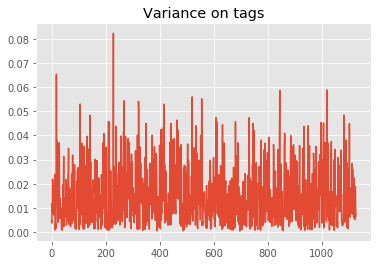

In [14]:
variances = dM.var(axis=1)
plt.plot(variances)
plt.title("Variance on tags")
plt.show()

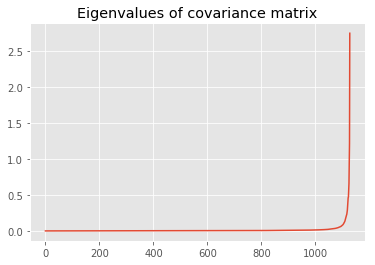

In [15]:
covar_m = np.cov(dM)
eigval, eigvec = np.linalg.eigh(covar_m)
plt.plot(eigval)
plt.title("Eigenvalues of covariance matrix")
plt.show()

## Exercise 3.2

In [16]:
eigvec

array([[ 0.00205699, -0.0053407 ,  0.0062789 , ...,  0.00124553,
        -0.01383799, -0.00572728],
       [-0.00078554, -0.00303118,  0.00347284, ...,  0.00206112,
        -0.01048045, -0.00478882],
       [ 0.00044356, -0.00104207,  0.00037798, ...,  0.02393293,
         0.00278201,  0.01246704],
       ..., 
       [ 0.00093566, -0.00050236,  0.00263286, ...,  0.03252862,
        -0.00551248,  0.01719115],
       [-0.00228662,  0.01518848,  0.00429738, ..., -0.0399581 ,
        -0.01417361, -0.01026643],
       [ 0.00059397, -0.01100711, -0.00067457, ..., -0.01634403,
        -0.00551606, -0.00137267]])

In [17]:
eigval[::-1]

array([  2.75337748e+00,   1.22147104e+00,   9.96051519e-01, ...,
         1.21317789e-04,   7.85936871e-05,   5.49031633e-05])

## Exercise 3.3

In [18]:
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")
    
for movie in movies[:3]:
    print(movie)

(780, 'Independence Day (a.k.a. ID4) (1996)', 0.6)
(5349, 'Spider-Man (2002)', 0.89)
(2571, 'Matrix, The (1999)', 0.87)
